## Simple analysis and visualisation of Trump's network, based on a BF article

### data from https://www.kaggle.com/skylord/trumpworld

### packages

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter}) # to have only 3 digit rounding - nicer
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
sns.set()

### data

In [2]:
path1 ="C://datasets//kaggle//Trump//datasets_868_1074664_Person_Person.csv"
path2 ="C://datasets//kaggle//Trump//datasets_868_1074664_Person_Org.csv"
path3 ="C://datasets//kaggle//Trump//datasets_868_1074664_Org_Org.csv"

# Person to Person

In [3]:
p2p = pd.read_csv(path1,encoding = "ISO-8859-1") # utf 8 doesn't work
p2p.sample(5)

Person A              Person B  \
249   STEPHEN MILLER            JULIA HAHN   
36   DONALD J. TRUMP         BRAD PARSCALE   
262      WILBUR ROSS         RUDY GIULIANI   
237   SERGEI MILLIAN       DONALD J. TRUMP   
173    JARED KUSHNER  NICOLE KUSHNER MEYER   

                                         Connection  \
249  Miller sent tips to Hahn, a Breitbart reporter   
36       Former digital director for Trump campaign   
262   Privatization advisor when Giuliani was mayor   
237   Appeared in a Facebook photo together in 2014   
173                                        Siblings   

                                             Source(s)  
249  http://www.politico.com/magazine/story/2016/06...  
36   http://www.politico.com/story/2017/01/new-pro-...  
262  http://www.salon.com/2016/11/21/wilbur-ross-jr...  
237  https://www.ft.com/content/ea52a678-9cfb-11e6-...  
173  http://www.townandcountrymag.com/society/polit...

### creating the adjecence matrix from this dataframe

In [5]:
p_a=p2p['Person A']
p_b=p2p['Person B']
persons = list(set(p_a.to_list()+p_b.to_list()))
print("Number of people in the dataset:",len(persons))

Number of people in the dataset: 232


In [7]:
# 232*232 zero matrix - index and columns are the persons, same order from the persons list
am = pd.DataFrame(np.zeros(shape=(len(persons),len(persons))),columns = persons, index=persons)

In [8]:
# going through the original p2p dataframe, and changing the adjecence matrix correspondent zeros to 1 
for i in range(p2p.shape[0]):
    am.loc[p2p.iloc[i,0],p2p.iloc[i,1]]=1
    am.loc[p2p.iloc[i,1],p2p.iloc[i,0]]=1

In [9]:
# creating the mapping list which we will use for the visualisation and clustering
key_list = []
for i in range(len(persons)):
    key_list.append(i)
mapping = dict(zip(key_list, persons))

In [19]:
am.iloc[62:70,43:48]

TRAVIS KALANICK  H. B. HICKS  DAVID SHULKIN  \
MURRAY KUSHNER                      0.0          0.0            0.0   
BOB DOLE                            0.0          0.0            0.0   
OMAROSÉ ONEE MANIGAULT              0.0          1.0            0.0   
RICK PERRY                          0.0          0.0            0.0   
ERIC UELAND                         0.0          0.0            0.0   
JESSICA DITTO                       0.0          0.0            0.0   
RYAN DOHERTY                        0.0          0.0            0.0   
LINDSAY WALTERS                     0.0          0.0            0.0   

                        DAVID HOROWITZ  CURTIS DUBAY  
MURRAY KUSHNER                     0.0           0.0  
BOB DOLE                           0.0           0.0  
OMAROSÉ ONEE MANIGAULT             0.0           0.0  
RICK PERRY                         0.0           0.0  
ERIC UELAND                        0.0           0.0  
JESSICA DITTO                      0.0           0.0  
RYAN DOHERTY                       0.0           0.0  
LINDSAY WALTERS                    0.0           0.0

very sparse matrix, not too many connections

In [20]:
# define the function which will draw our graph
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos,font_size =16)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

### visualisation

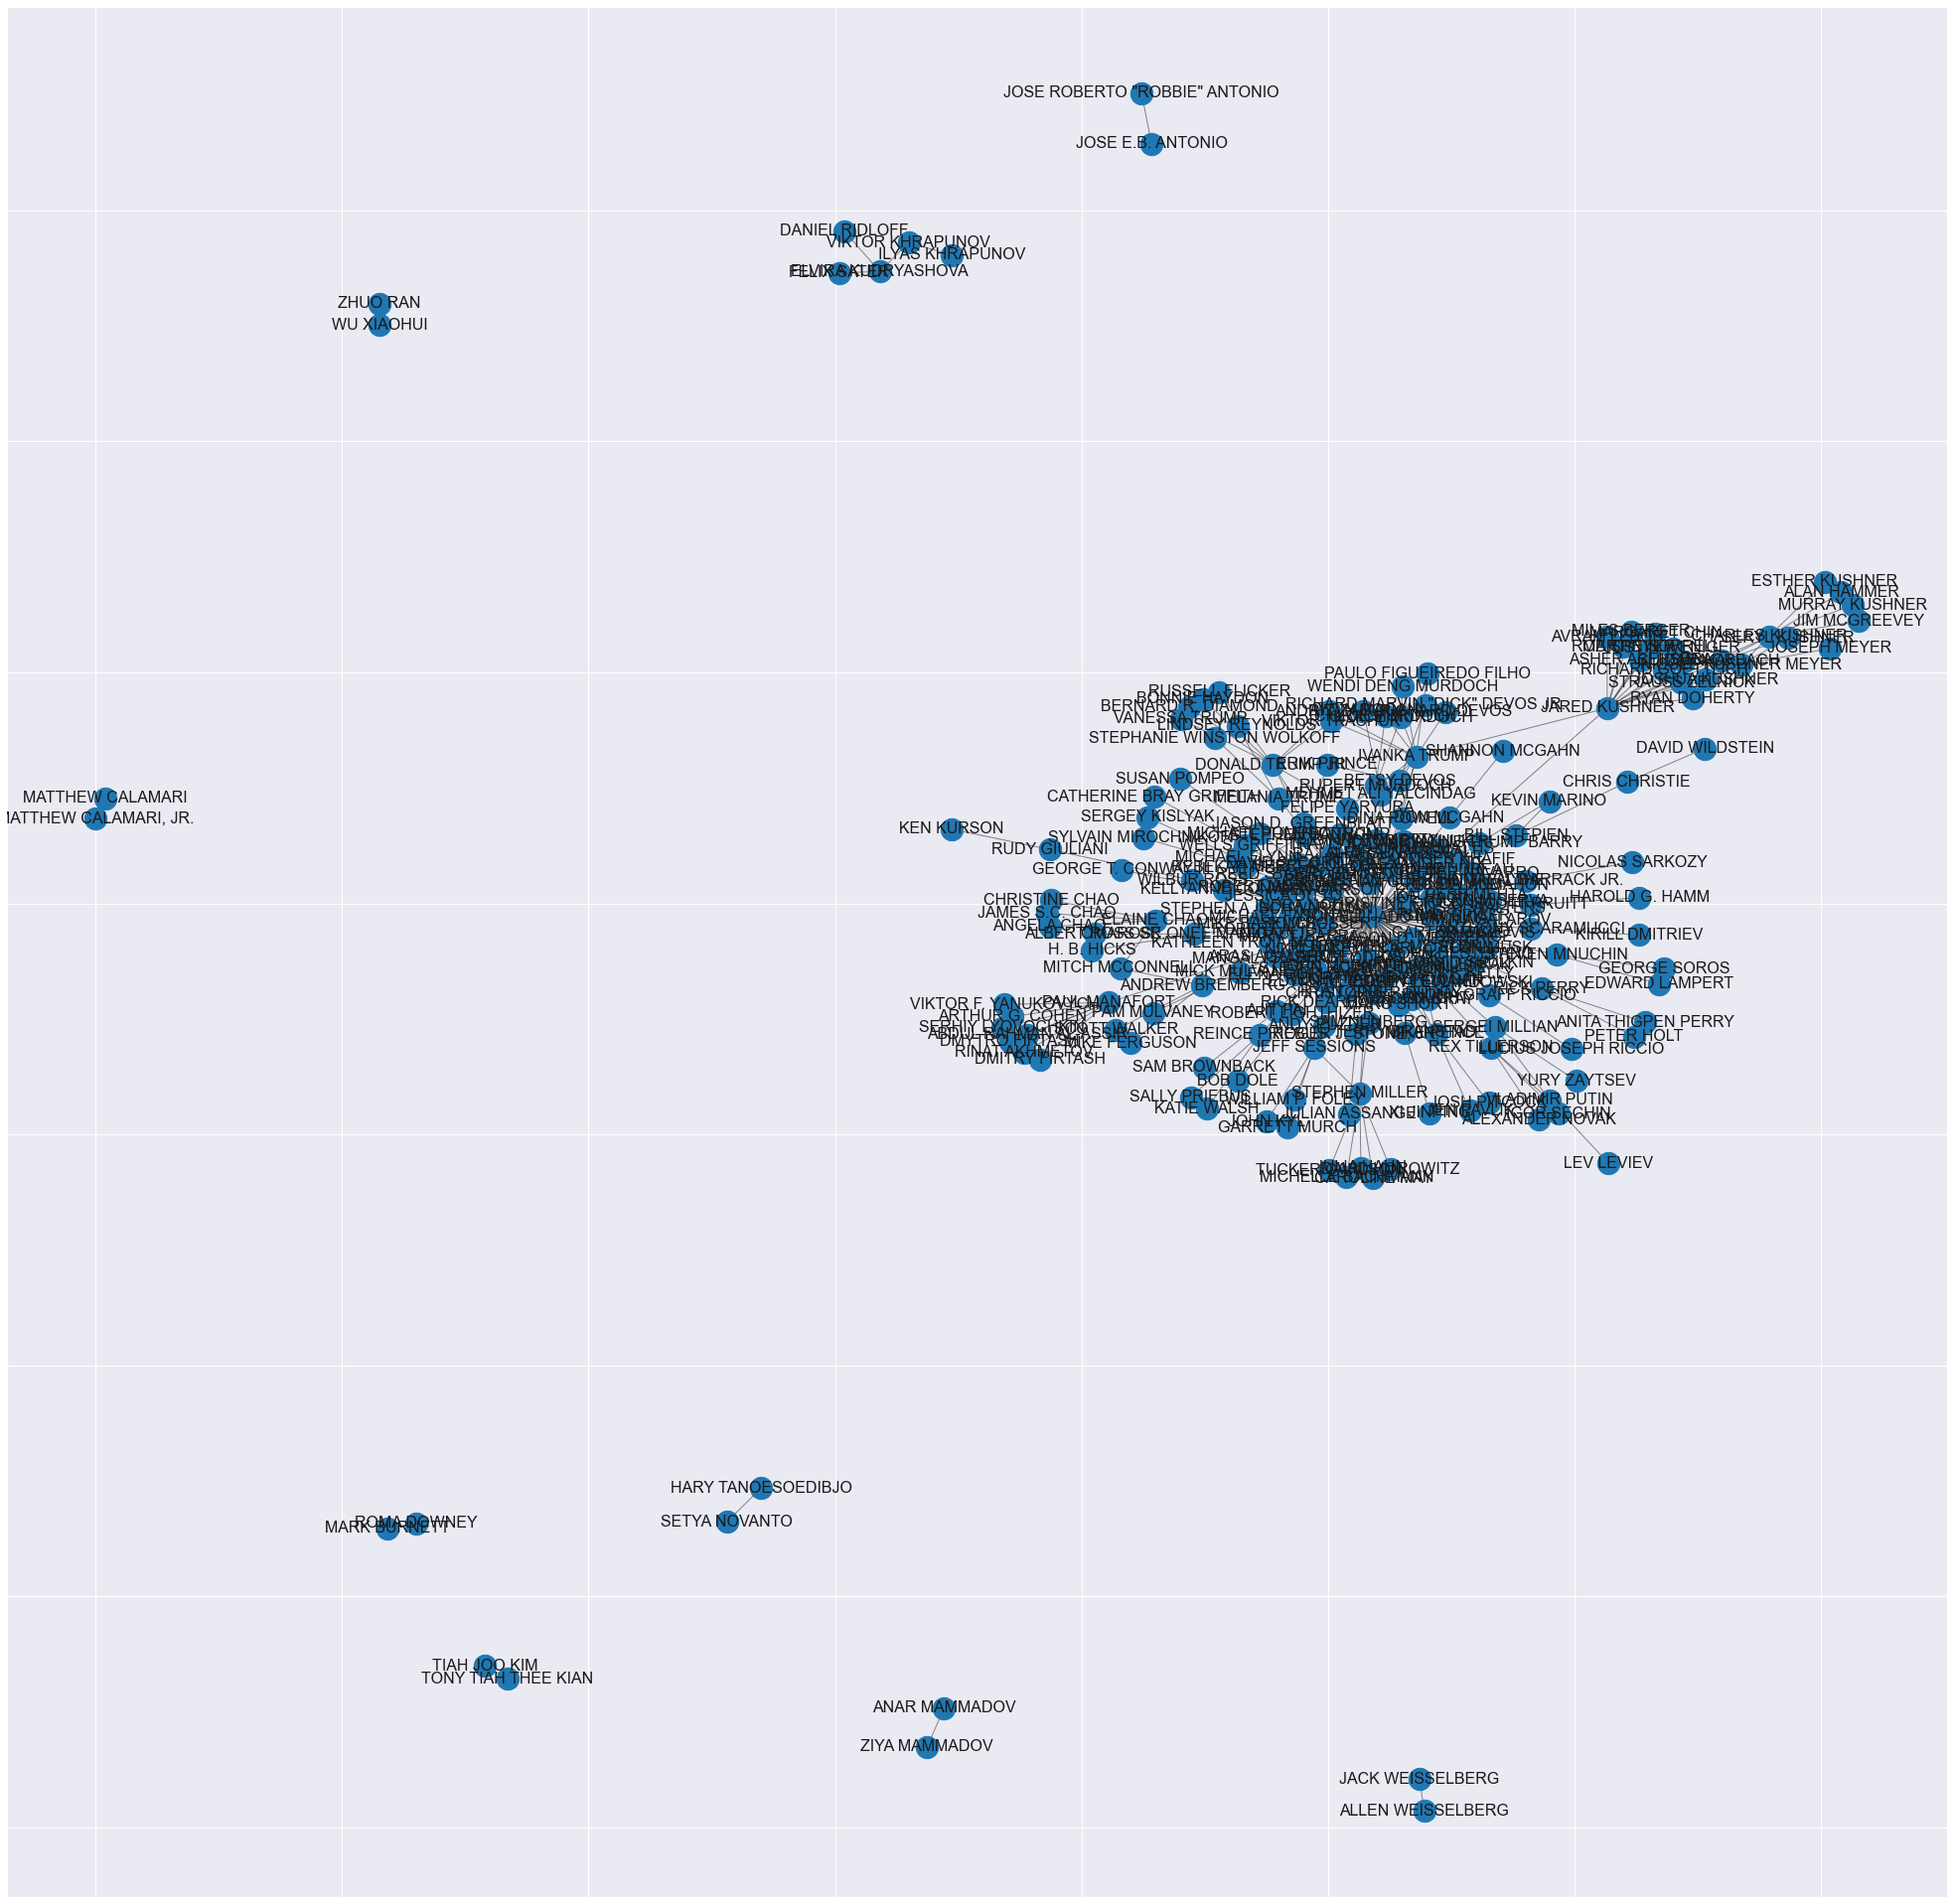

In [21]:
X = np.array(am)

G = nx.from_numpy_matrix(X) # from adjecenct matrix this is the G Graph
H = nx.relabel_nodes(G, mapping) # I apply the new names
plt.figure(figsize=(35,35))
pos = nx.spring_layout(H,k=5,iterations=20)
draw_graph(H)

### core component

several components, seems trivial that each connected components are a separate cluster. So focus only on the big one

In [22]:
# separate the graph into subgraphs and check teir sizes
graphs = list(G.subgraph(c) for c in nx.connected_components(G))
for i in range(len(graphs)):
    print(i, len(graphs[i]))

0 2
1 211
2 5
3 2
4 2
5 2
6 2
7 2
8 2
9 2


In [31]:
New_Graph = graphs[1]
list(New_Graph.nodes)
dic_new={}
for i in list(New_Graph.nodes):
    dic_new[i] = persons[i]
[v for v in list(dic_new.values())[:10]]

['KIRILL DMITRIEV',
 'LINDA MCMAHON',
 'DINA POWELL',
 'MILES BERGER',
 'ALEXANDER NIX',
 'SHERI A. DILLON',
 'ROBERT A. IGER',
 'EDWARD LAMPERT',
 'RICK DEARBORN',
 'SAM CLOVIS']

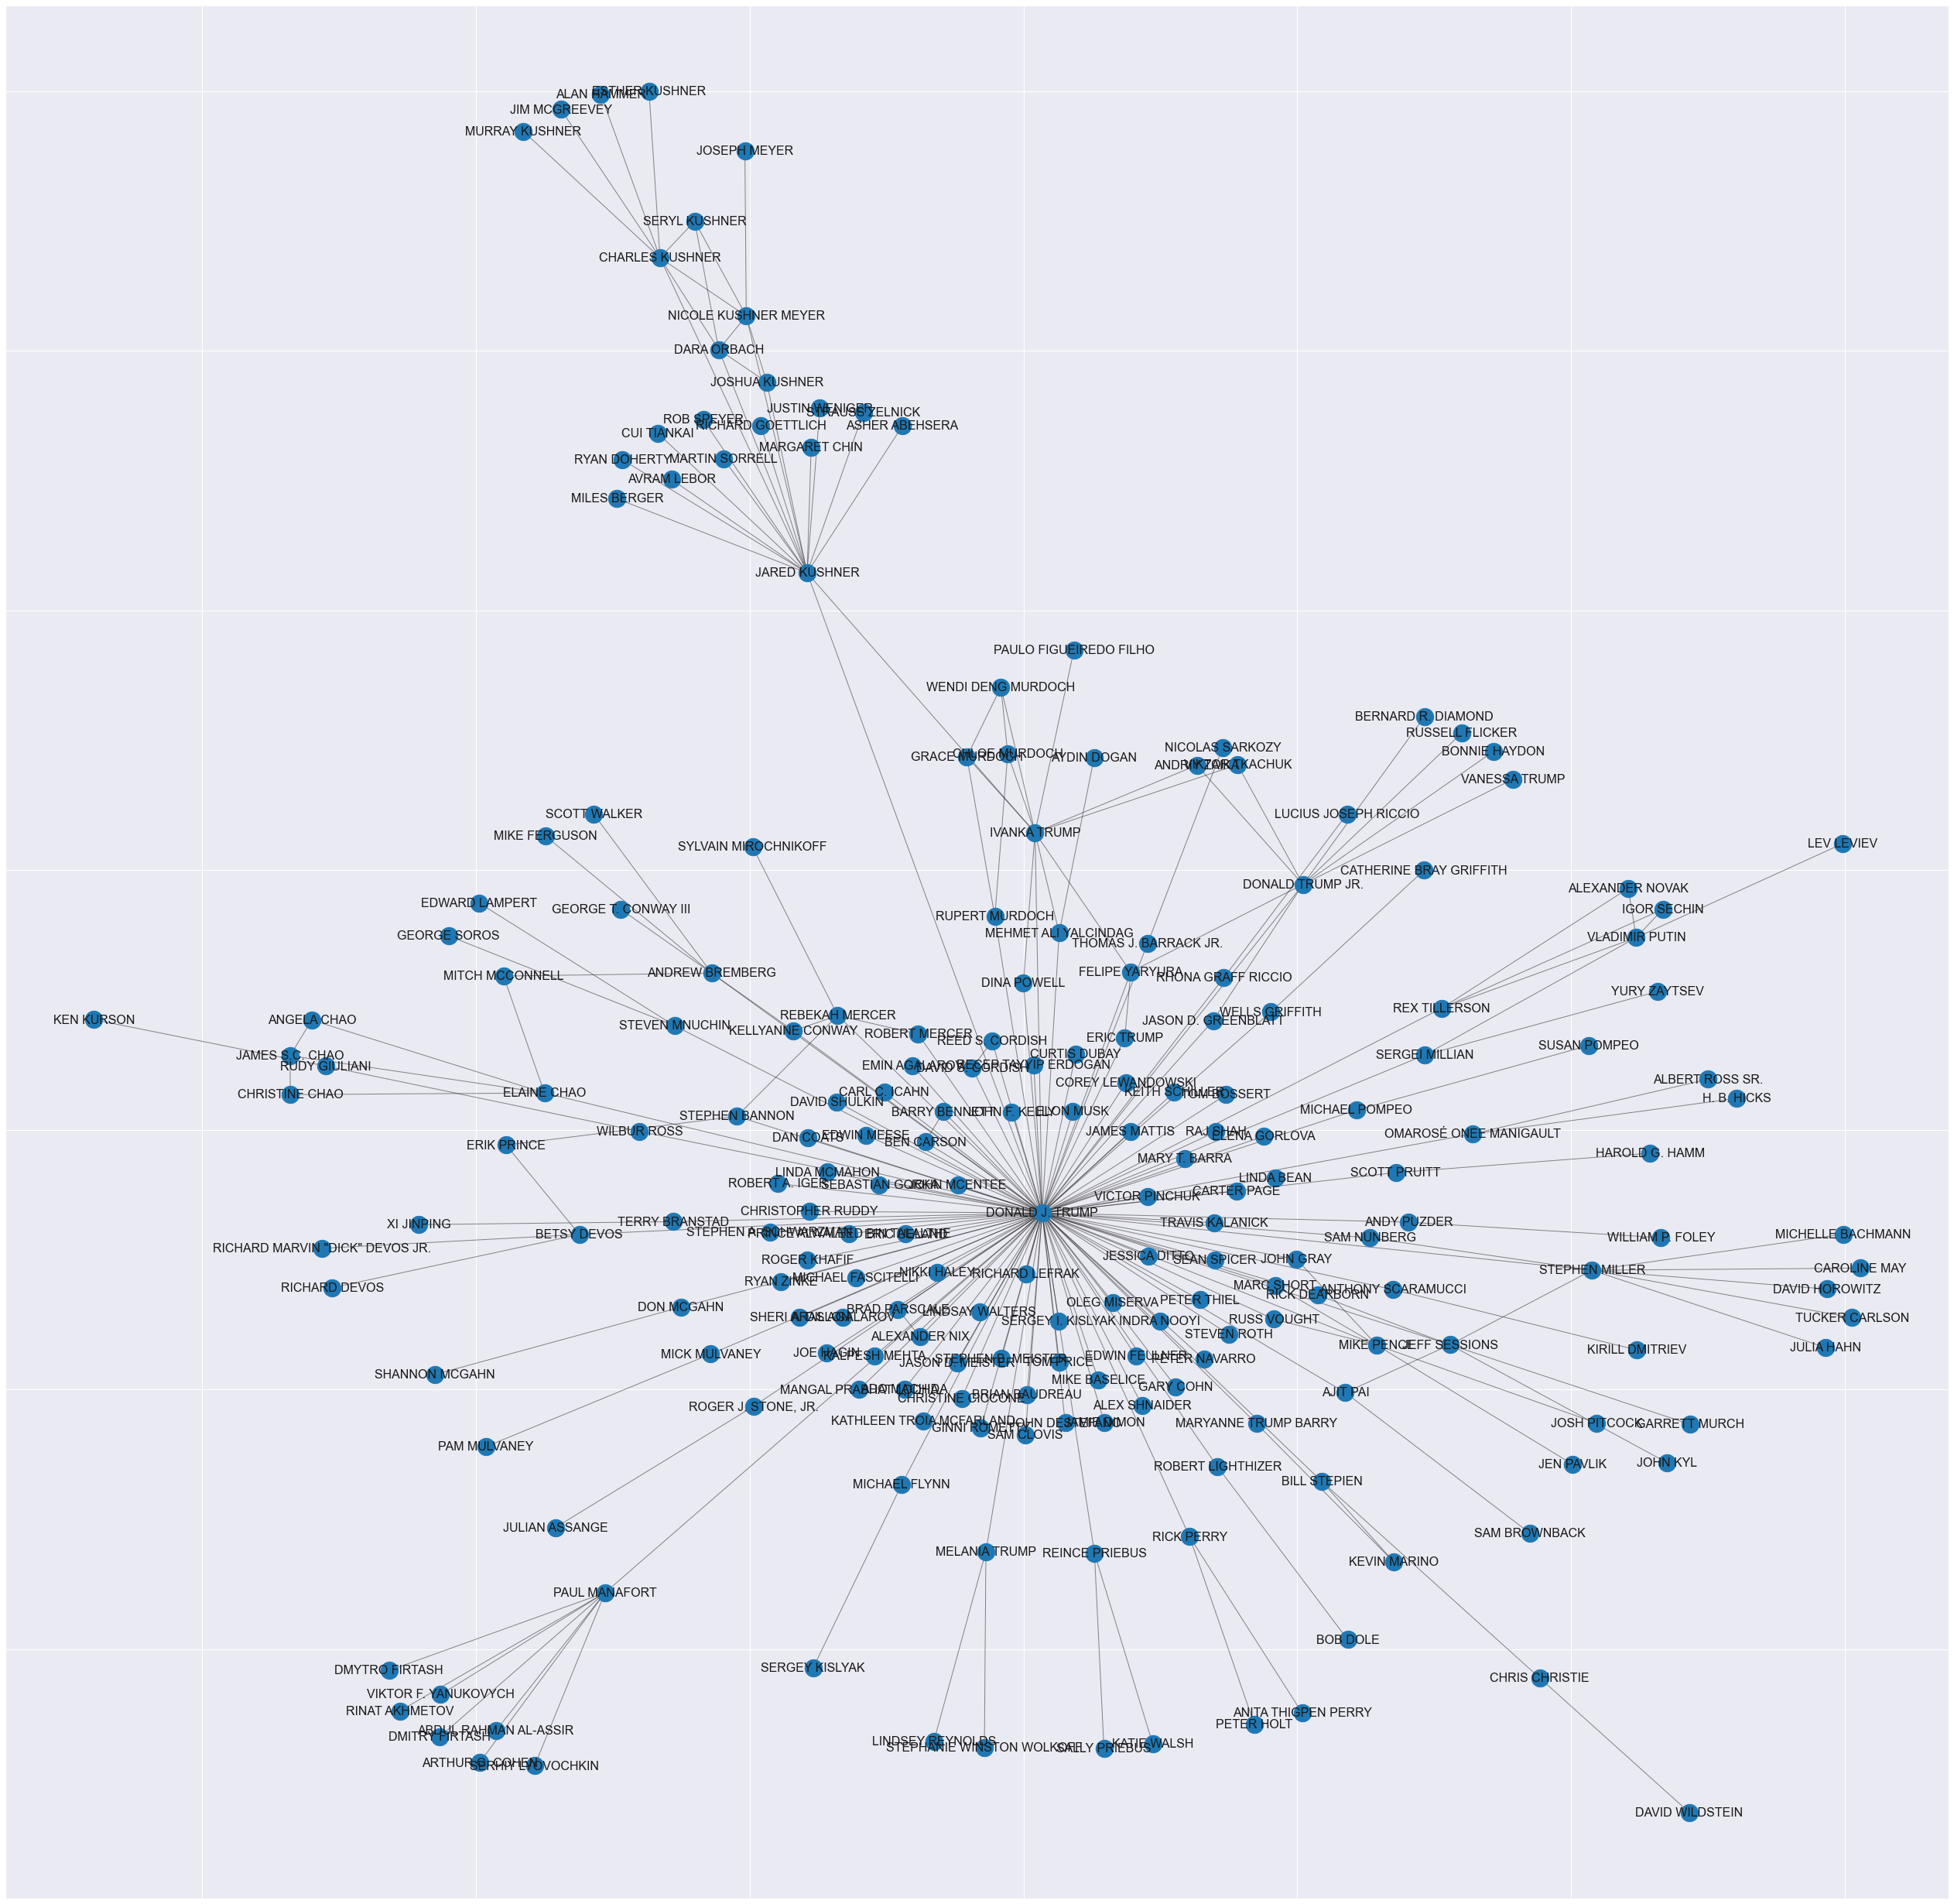

In [32]:
H2 = nx.relabel_nodes(New_Graph, dic_new) # I apply the new names
plt.figure(figsize=(45,45))
pos = nx.spring_layout(H2,k=5,iterations=20)
draw_graph(H2)
#plt.savefig("trump_inner1.png")

this seems a nice connected graph, we can start clustering on it

### spectral clustering

In [33]:
W = nx.adjacency_matrix(H2)
print(W.todense())

[[0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 ...
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]]


In [34]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[1.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 1.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 2.000 ... 0.000 0.000 0.000]
 ...
 [0.000 0.000 0.000 ... 1.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 1.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 1.000]]
laplacian matrix:
[[1.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 1.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 2.000 ... 0.000 0.000 0.000]
 ...
 [0.000 0.000 0.000 ... 1.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 1.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 1.000]]


In [35]:
e, v = np.linalg.eigh(L) # eig sometimes gives complex number with imaginary part close to 0. eigh .This works directly for Hermitian matrices, and so will have only real Eigen values
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[-0.000 0.076 0.117 0.199 0.211 0.217 0.227 0.253 0.268 0.268 0.268 0.268
 0.282 0.307 0.334 0.382 0.382 0.382 0.382 0.382 0.382 0.382 0.382 0.382
 0.382 0.382 0.382 0.402 0.422 0.430 0.461 0.468 0.513 0.560 0.631 0.664
 0.672 0.725 0.747 0.785 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.083 1.263 1.506 1.552 1.576
 1.597 1.680 1.681 1.755 1.825 1.911 1.913 1.992 2.000 2.000 2.000 2.000
 2.000 2.000 2.561 2.618 2.618 2.618 

In [36]:
np.where(e < 0.01)

(array([0], dtype=int64),)

first eiegen value is 0, so it's really a connected graph

In [37]:
# very littel eigenvalues:
np.where(e <0.382)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64),)

In [40]:
i = np.where(e < 0.382)[0] # tiny eigenvalues

U = np.array(v[:, [i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9],i[10],i[11],i[12],i[13],i[14],
                   i[15],i[16],i[17],i[18],i[19],i[20],i[21],i[22],i[23],i[24],i[25],i[26]]]) # 26 eigenvector matrix
km = KMeans(init='k-means++', n_clusters=26) # let's do 26 clusters
km.fit(U)
km.labels_

array([17,  1,  1,  3,  1,  1,  1,  4,  1,  1,  2,  1, 24,  1,  1,  1,  3,
        3,  1, 24,  1,  1,  1,  1,  3,  1,  7,  1, 22,  3, 19,  1,  5,  1,
        1,  1,  1,  1, 25,  1,  9,  1, 24,  1,  1,  1, 21,  0,  7,  1,  6,
        1,  1, 25, 14,  1,  1,  1,  3, 15,  9, 13,  1,  1,  3,  1, 18, 24,
        1, 18,  7,  1,  5,  1,  3,  1,  6,  5,  1,  3,  1,  1,  2, 15, 11,
       24,  1,  1,  1,  3,  3,  3,  3,  1,  1,  5,  1, 22,  1,  1,  1,  1,
        1,  2,  3,  1,  1, 20,  1, 11,  1,  1,  1,  1,  3,  1, 14, 13,  1,
       19,  2,  1,  1,  1,  2, 23, 20,  1, 10,  7,  1, 13,  1,  0,  0,  1,
        1,  7,  3,  1,  1, 16,  2,  1,  1,  6,  1,  1, 10,  1,  1,  1,  7,
       24,  1,  1, 21,  2,  3,  1,  5,  1,  1,  1,  1, 10,  3,  3,  3,  1,
        1, 11,  9, 24,  1, 16,  1,  7,  8,  5,  1,  1,  8,  0,  1, 12,  3,
        5,  3,  1, 17,  1,  1,  4,  1, 12,  7,  1, 24,  1,  1, 23,  1, 24,
        1,  5, 24,  4,  1,  1,  1])

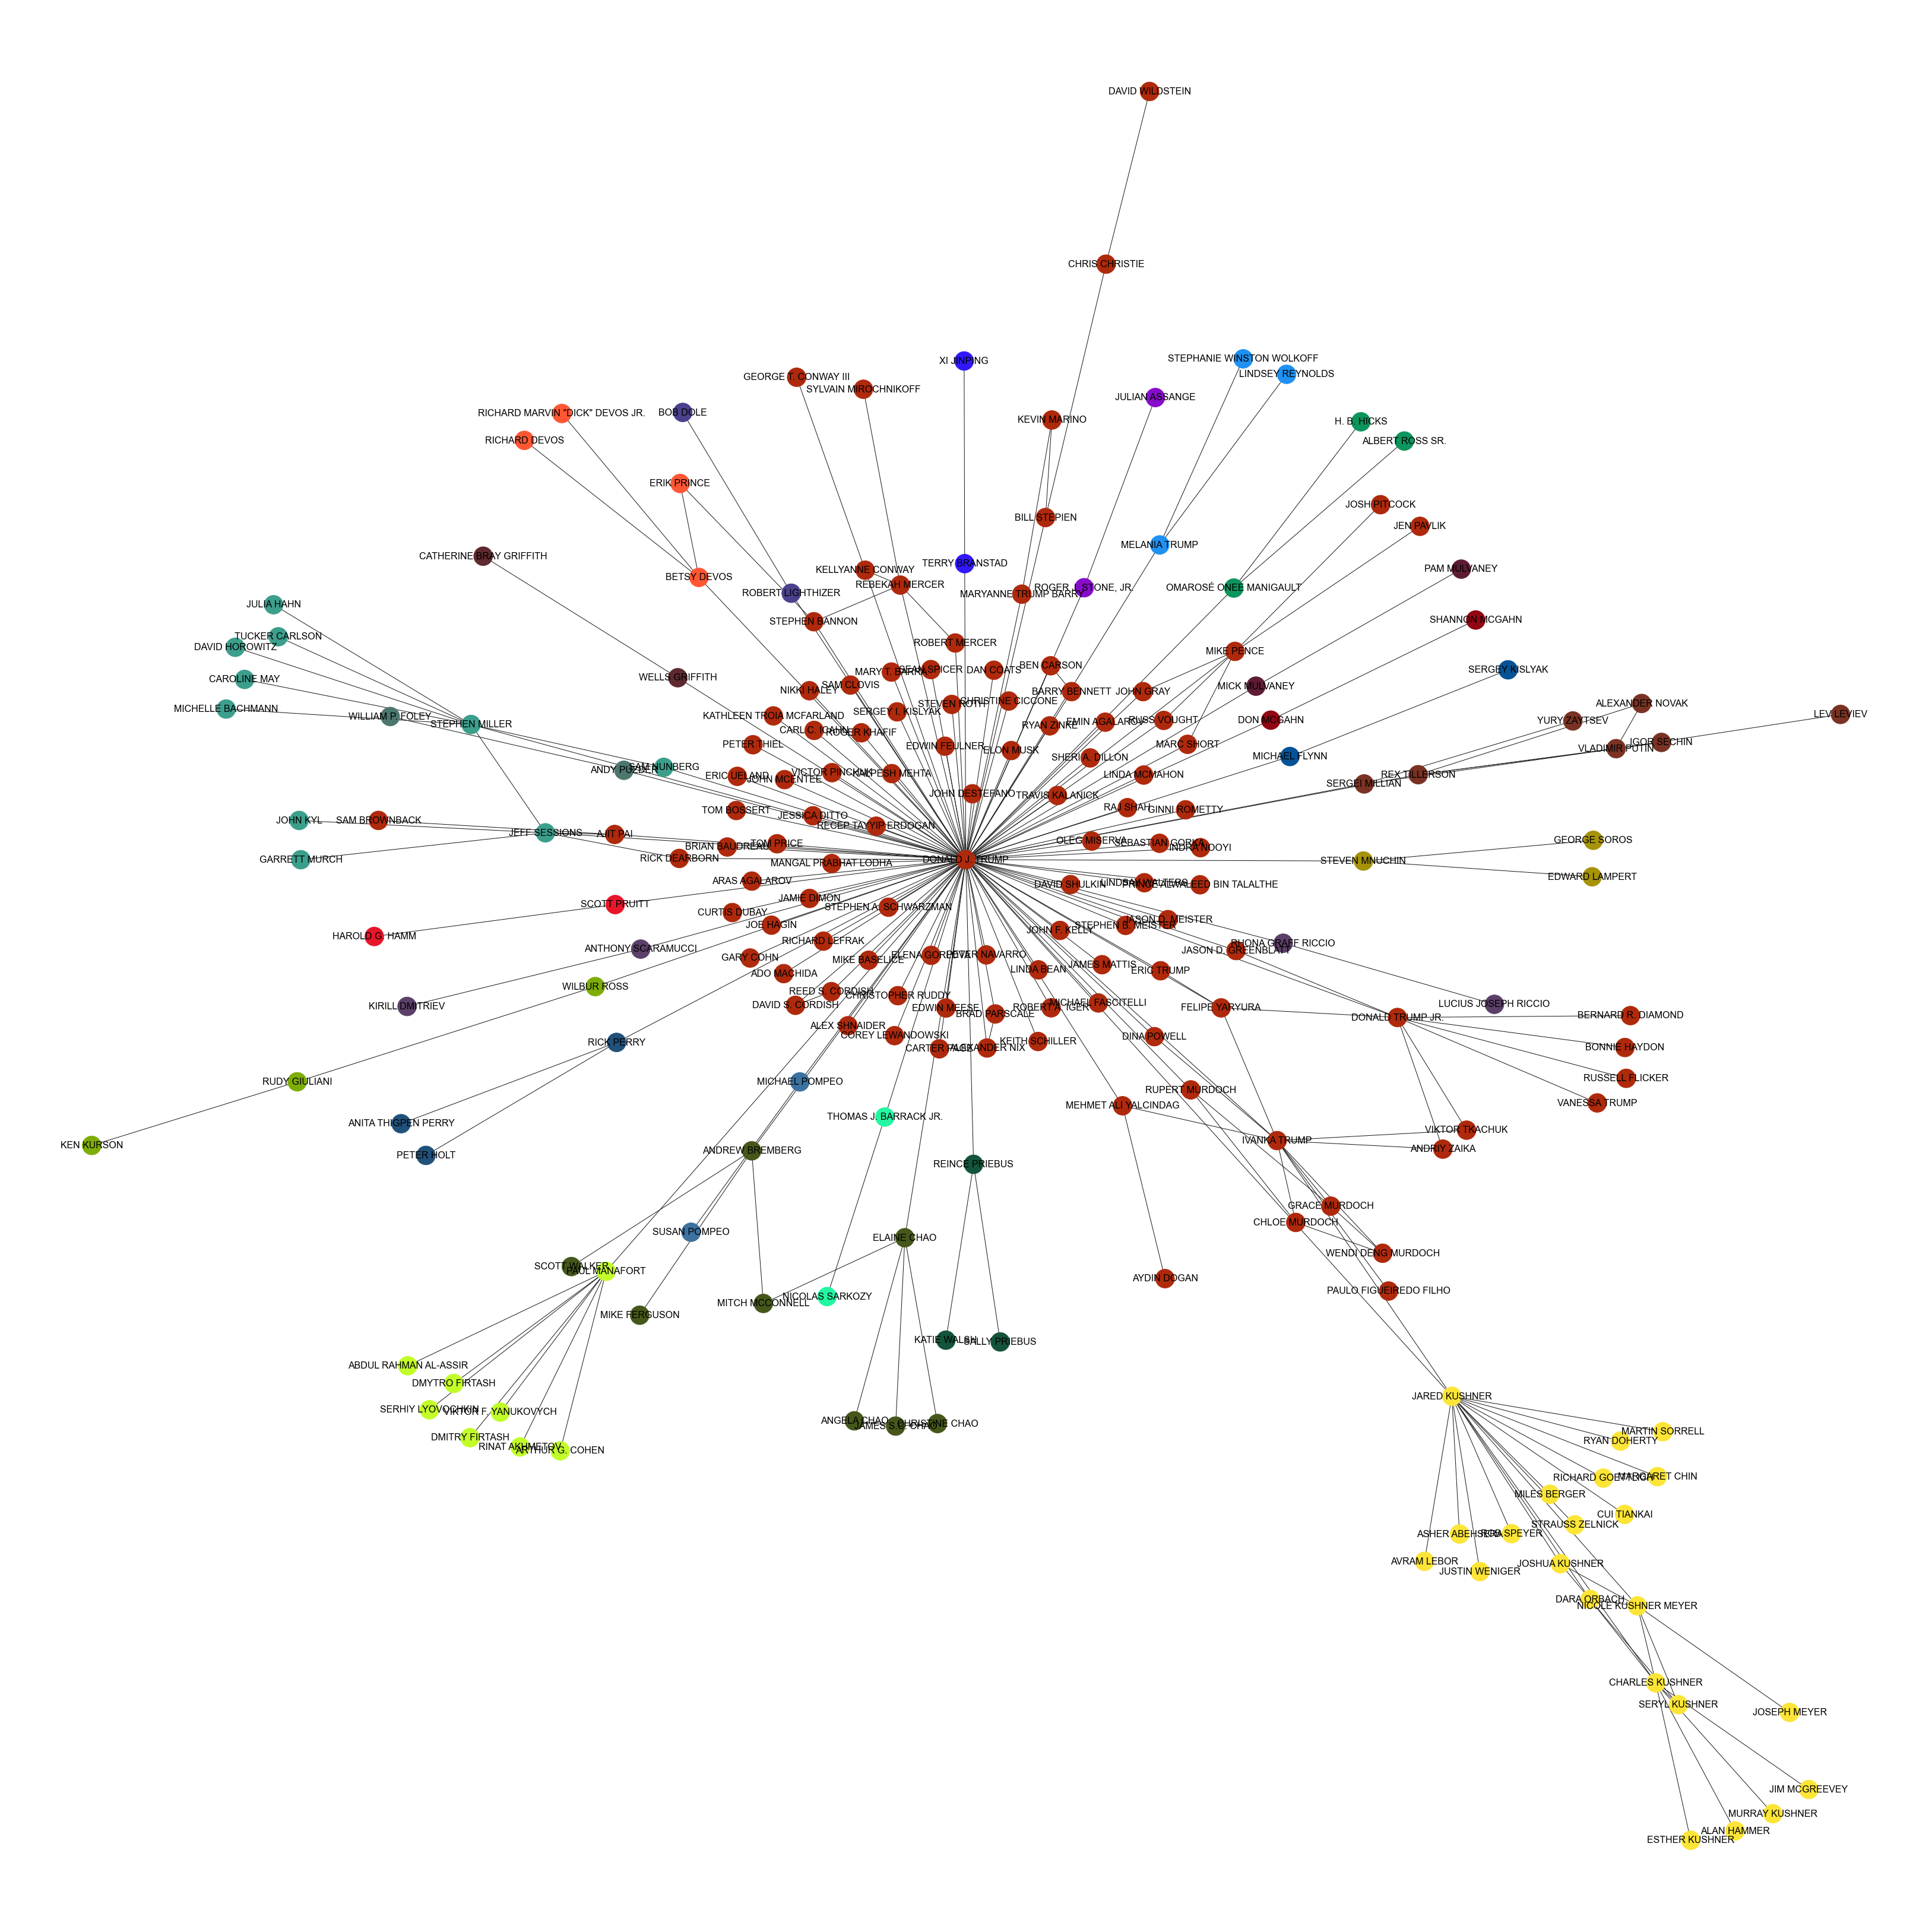

In [42]:
# O just picked a bunch of colours which can be used anytime later: https://htmlcolorcodes.com/color-picker/
thirty_hex = ['#FF5733','#AF290C','#793223','#FCE537','#A69309','#C2FD2A','#7FAD08','#46571B',
              '#23F7A1','#0D955E','#13543A','#1E91F3','#055294','#21517B','#3118FC','#49418C',
              '#870DCA','#5B4069','#5B4069','#5D1C34','#E81629','#910613','#5E2A2F','#3C729F',
              '#3C9F8C','#4D766E','#499567','#4EBF48','#0D7C07','#BBC017']

colors = thirty_hex[:27]    #['yellow','green','red', 'orange']
#fcolors = ['red', 'black', 'black']
color_map = []
fcolor_map = []
for node in range(len(New_Graph)):
    color_map.append(colors[km.labels_[node]])
    #fcolor_map.append(fcolors[km.labels_[node]])
plt.figure(figsize=(45,45))
nx.draw(H2, node_color=color_map, with_labels=True, font_size=16 ,node_size = 1000,font_color = 'black' )
plt.savefig("trump_inner1.png")

    Nicely separated clusters, for example the right bottom yellow Jared Kushner cluster
    Next step will be the average distance from trump in the different clusters